In [1]:
import numpy as np
import pandas as pd
import networkx as nx


In [12]:
class Path:
    def __init__(self, path):
        self.path = path
        self.traversed_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        self.travel_time = None
    def update_travel_time(self, link_time):
        self.travel_time = sum([link_time[edge] for edge in self.traversed_edges])


class TrafficAssignment:
    def __init__(self, file_path, od_path, node_attr, instance_name="sample", algorithm_name ="FW", eps=1e-3):
        G = self.create_network(file_path, node_attr)
        self.graph=G
        od, od_demand = self.get_od(od_path=od_path, od_mask=None)
        self.od=od
        self.od_demand=od_demand
        self.beta = self.get_edge_attributes('beta')
        self.alpha = self.get_edge_attributes('alpha')
        self.fftt = self.get_edge_attributes("travel_time")
        self.capacity = self.get_edge_attributes("capacity")
        self.eps=eps
        self.edges = list(self.graph.edges())
        self.nodes = list(self.graph.nodes())
        self.num_edges = len(self.edges)
        self.num_nodes = len(self.nodes)
        self.link_time = np.zeros(self.num_edges)
        self.link_flow = np.zeros(self.num_edges)
        self.iteration = 0
        self.converged = False
        self.old_gap=1e9
        self.UE_sol = 1e6*np.ones(self.num_edges)
        self.algorithm_name = algorithm_name
        if self.algorithm_name in ["FW","MSA"]:
            self.pqs = None
            self.link_flows = None
        elif self.algorithm_name == "PBA":
            self.pqs = [[] for _ in range(len(self.od))] 
            self.list_flows = [[] for _ in range(len(self.od))]
        else:
            raise ValueError(f"Alogrithm name {self.algorithm_name} not support.")
        if instance_name == 'SiouxFalls':
            self.UE_sol_LB = 4231335.28710744
        elif instance_name == 'sample':
            self.UE_sol_LB = 1719653.819467463
        else:
            raise ValueError("instance name not found")
    
    def get_od(self, od_path, od_mask=None):
        od = pd.read_csv(od_path)
        ods = od[['O', 'D']].values.tolist()
        ods_demand = od['Ton'].values.tolist()
        return ods, ods_demand
    
    def get_edge_attributes(self, attributes):
        '''
        get edge attributes: capacity, beta, alpha, travel_time, traffic_flow
        '''
        vals = nx.get_edge_attributes(self.graph,attributes).values()
        return np.array(list(vals))
    
    
    def step_pba(self, metric = "relative_gap"):
        '''
        path-based algorithm with gradient projection
        '''
        # first, find the shortest path for each OD pair
        if self.iteration==0:
            for od_pair, od_demand, pq, list_flow in zip(self.od, self.od_demand,self.pqs,self.list_flows):
                init_sp, init_sp_cost = self.get_shortest_path_single_od(od_pair)
                init_traversed_arcs = [(i,j) for i,j in zip(init_sp[:-1],init_sp[1:])]
                # put the shortest path to the priority queue with the cost as the priority
                pq.append(init_traversed_arcs) # ([init_sp,init_sp_cost,od_demand]) # append shortest path and demand
                list_flow.append(od_demand)
                self.update_path_to_link_flow_single_od([],init_traversed_arcs, od_demand)
                self.update_travel_time()

        else:
            # next update new shortest path for each OD pair
            for od_pair, od_demand, pq, list_flow in zip(self.od, self.od_demand, self.pqs,self.list_flows):
                basic_path, basic_path_cost = self.get_shortest_path_single_od(od_pair) # based on the updated travel time
                basic_path_traversed_arcs = [(i,j) for i,j in zip(basic_path[:-1],basic_path[1:])]

                used_path_cost, basic_path_id = self.update_travel_time_for_path_set(pq, basic_path_traversed_arcs)

                if basic_path_id is None: # it's a new path:
                    basic_path_flow = 0
                else:
                    basic_path_flow = list_flow[basic_path_id]
                # for each non-basic paths, adjust the flow:
                for i in range(len(pq)):
                    if i != basic_path_id:
                        non_basic_traversed_arcs = pq[i]
                        non_basic_path_cost = used_path_cost[i]
                        # get the shift flow
                        path_cost_diff = non_basic_path_cost-basic_path_cost # non-negative
                        # then get dev_sum
                        dev_sum = self.get_sum_of_gradient(basic_path_traversed_arcs, non_basic_traversed_arcs)
                        flow_to_shift = min(list_flow[i],path_cost_diff/dev_sum)
                        list_flow[i] -= flow_to_shift
                        basic_path_flow += flow_to_shift

                        self.update_path_to_link_flow_single_od(non_basic_traversed_arcs,basic_path_traversed_arcs, flow_to_shift)

                # finally, update the basic path flow
                if basic_path_id is None: # it's a new path:
                    list_flow.append(basic_path_flow)
                    pq.append(basic_path_traversed_arcs)
                else:
                    list_flow[basic_path_id] = basic_path_flow

                # self.update_path_to_link_flow_single_od(used_traversed_arcs, sp_traversed_arcs, shift_flow)
                self.update_travel_time()
        # drop the paths with zero flow
        for od_pair, od_demand, pq, list_flow in zip(self.od, self.od_demand, self.pqs, self.list_flows):
            indices_to_remove = [i for i, flow in enumerate(list_flow) if flow < self.eps]
            for i in sorted(indices_to_remove, reverse=True):
                del pq[i]
                del list_flow[i]
        # check the relative gap
        if metric == "relative_gap":
            gap = np.sum(self.UE_sol)/(self.UE_sol_LB)-1 # initial one is sufficiently large
            if gap < self.eps:
                self.converged = True
        else:
            raise ValueError("metric should be AEC or relative_gap")

        print("iteration: {}, gap: {}".format(self.iteration, gap))

        self.iteration += 1
        # one more thing to do: update the travel time for each path under the same OD.
        self.save_UE_cost_function()
        return gap
    
    
    def get_shortest_path(self):
        list_sp = [nx.dijkstra_path(self.graph, self.od[i][0], self.od[i][1], weight='travel_time') for i in range(len(self.od))]
        list_sp_cost = [np.sum([self.graph[i][j]["travel_time"] for (i,j) in zip(sp,sp[1:])]) for sp in list_sp]
        return list_sp, list_sp_cost

    def map_path_to_link_flow(self, path):
        '''
        map the shortest path to link flow
        '''
        link_flow = np.zeros(self.num_edges)

        for pid,p in enumerate(path):
            for i in range(len(p) - 1):
                link_flow[self.edges.index((p[i], p[i + 1]))] += self.od_demand[pid]
        return link_flow
    
    def save_UE_cost_function(self):
        '''
        save the UE cost function to the graph
        '''
        self.UE_sol = self.fftt*self.link_flow + self.capacity/(self.alpha+1)*self.fftt*self.beta*(self.link_flow/self.capacity)**(self.alpha+1)
    
    def update_travel_time(self):
        # update link travel time
        self.link_time = self.fftt*(1+self.beta*(self.link_flow/self.capacity)**self.alpha)
        # then update the link_time to each edge attribute
        for e,tt in zip(self.edges,self.link_time):
            self.graph[e[0]][e[1]]["travel_time"]=tt #update link travel time in the graph

    def update_link_flow(self):
        '''
        updated link flow (according to the shortest path)
        theta: step size (default: 1, bisection method)
        '''
        # update the link_flow to each edge attribute
        for e,f in zip(self.edges,self.link_flow):
            self.graph[e[0]][e[1]]["travel_flow"]=f

    def save_shortest_path(self,shortest_path):
        '''
        save the shortest path to the graph
        '''
        self.graph._shortest_path = shortest_path

    def get_graph(self):
        return self.graph


    def bisection_search(self,x1,x2,eps=1e-8):
        '''
        bisection search         
        for the optimal step size: lambda
        the goal is to minimize the gap
        old link flow --x--x---o------ new link flow
        '''
        l = 0
        l_ = 1
        n_iter = 0  # iteration
        while abs(l_ - l) > eps:  # stopping criteria
            c = self.compute_gradient(x1, x2, (l + l_) / 2)
            if c > 0:
                l_ = l + (l_ - l) / 2
            else:
                l = l + (l_ - l) / 2
            n_iter += 1
        return (l + l_) / 2, n_iter


    def fsolve_search(self,x1,x2,eps=1e-8):
        '''
        the goal is to minimize the gap
        '''
        def formula():
            '''
            x1: the current link flow assignment
            x2: the shortest path flow assignment
            lbd: lambda ratio
            '''
            # flow = (1 - lbd) * x1 + lbd * x2
            d=x2-x1
            link_cost = (self.fftt * (1 + self.beta * (x1 / self.capacity) ** self.alpha))
            hessian=np.diag(self.fftt*self.beta*self.alpha/self.capacity*(x1/self.capacity)**(self.alpha-1))

            tau= -link_cost.T@d/(d.T@hessian@d)

            return tau

        tau = formula()
        return tau

    def compute_gradient(self,x1,x2,lbd):
        '''
        x1: the current link flow assignment
        x2: the shortest path flow assignment
        lbd: lambda ratio
        '''
        flow=(1-lbd)*x1+lbd*x2
        link_cost=(self.fftt*(1+self.beta*(flow/self.capacity)**self.alpha))@(x2-x1)
        return link_cost

    @staticmethod
    def create_network(filepath,node_attr_path):
        '''
        Create a network from a csv file
        '''
        net = pd.read_csv(filepath)
        node_attr = pd.read_csv(node_attr_path)
        G = nx.DiGraph()
        for _, row in net.iterrows():  # iterate over all rows
            edge_id, fn, tn, tt_, capacity_, beta_, alpha_ = row  # unpack your attributes
            G.add_edge(fn, tn, edge_index = edge_id, travel_time=tt_, travel_flow=0, capacity=capacity_, beta=beta_, alpha=alpha_)
        # add node attributes
        for _, row in node_attr.iterrows():
            node, x, y = row
            G.add_node(node, x=x, y=y)

        return G
    
    @staticmethod
    def convex_combination(x, y, theta):
        return (1-theta)*x + theta*y

    
    def get_shortest_path_single_od(self,od):
        '''
        get the shortest path for a single od pair
        '''
        sp = nx.dijkstra_path(self.graph, od[0], od[1], weight='travel_time')
        sp_cost = np.sum([self.graph[i][j]["travel_time"] for (i,j) in zip(sp,sp[1:])])
        return sp, sp_cost
    
    
    def update_path_to_link_flow_single_od(self, path_flow_out, path_flow_in, shift_flow):
        '''
        map the shortest path to link flow
        '''
        if len(path_flow_out)>0:
            for i,j in path_flow_out:
                self.link_flow[self.edges.index((i,j))] -= shift_flow


        for i,j in path_flow_in:
            self.link_flow[self.edges.index((i,j))] += shift_flow


    
    def update_travel_time_for_path_set(self, pq, basic_path_traversed_arcs):
        '''
        update travel time for a set of paths
        output: list of travel time for each path, and the basic path id (if has)
        '''
        used_flag = False
        used_path_cost = []
        basic_path_id = None

        i = 0
        # update travel costs for all paths within the same OD.
        for used_traversed_arcs in pq:
            if not used_flag:
                if set(basic_path_traversed_arcs) == set(used_traversed_arcs):
                    used_flag = True
                    basic_path_id = i

            used_path_cost.append(self.get_travel_time_from_path(used_traversed_arcs))
            i += 1
        return used_path_cost, basic_path_id
    
    
    def get_travel_time_from_path(self, sp):
        '''
        get the travel time based on the shortest path (list of nodes)
        '''
        t = 0
        for i,j in sp:
            t += self.graph[i][j]['travel_time']
        return t


    def get_sum_of_gradient(self,sp1,sp0):
        '''
        get the sum of derivatives of links.
        '''
        # get the links in sp1 but not in sp0
        link_sp1 = set(sp1)
        link_sp0 = set(sp0)
        # find the links that contribute to either sp1 or sp0
        link_contributed = link_sp1.symmetric_difference(link_sp0)

        # get a masked edge list
        masked_edge_cost = np.zeros(len(self.edges))
        for link in link_contributed:
            masked_edge_cost[self.edges.index(link)] = 1
        dev_sum=np.sum(self.fftt*self.beta*self.alpha/self.capacity*(masked_edge_cost*self.link_flow/self.capacity)**(self.alpha-1))

        return dev_sum

In [13]:
# read data
instance_name = "SiouxFalls" # "sample" # 
file_path = f'network_data/{instance_name}/network_net.csv'
node_attr = f'network_data/{instance_name}/network_node.csv'

N_iter = 500 # number of iterations
eps = 1e-8 # tolerance

# then we run the FW algorithm
algorithm_name = "PBA" # Path-Based Algorithm

with open(f'results/{instance_name}/results_{algorithm_name}.csv', 'w') as f:
    for od_path in glob.glob(f"network_data/{instance_name}/network_od*.csv"):

        model = TrafficAssignment(file_path, od_path, node_attr, instance_name, algorithm_name, eps) # set up the model

        # record the relative gap and the number of iterations
        gaps_pba=[]
        n_iters_pba=[]

        while (not model.converged) and model.iteration<N_iter:
            gap = model.step_pba(metric="relative_gap")
            gaps_pba.append(gap)
            n_iters_pba.append(model.iteration)
            if model.iteration % 100 == 0:
                print('iteration: {}, gap: {}'.format(model.iteration, gap))
            # record iteration and solution
            f.write(f"{model.iteration},{gap},{np.sum(model.UE_sol)}\n")

        break # only run one OD pair    

iteration: 0, gap: 16.96123323801975
iteration: 1, gap: 0.21645426994872063
iteration: 2, gap: 0.027963911784392392
iteration: 3, gap: 0.00770785133566676
iteration: 4, gap: 0.0029247484397576518
iteration: 5, gap: 0.0017841770656625844
iteration: 6, gap: 0.0010128248414758012
iteration: 7, gap: 0.0006047502143260441
iteration: 8, gap: 0.0003531196108716994
iteration: 9, gap: 0.000217012325720356
iteration: 10, gap: 0.00012692997880558998
iteration: 11, gap: 6.886187450017012e-05
iteration: 12, gap: 2.8367962022546322e-05
iteration: 13, gap: 2.8147393276167776e-06
iteration: 14, gap: 1.4466602002993767e-06
iteration: 15, gap: 9.662381841302192e-07
iteration: 16, gap: 7.243190236483343e-07
iteration: 17, gap: 5.548861481408096e-07
iteration: 18, gap: 4.283623464829134e-07
iteration: 19, gap: 3.3664005849587397e-07
iteration: 20, gap: 2.6740534875280275e-07
iteration: 21, gap: 2.1315525433607263e-07
iteration: 22, gap: 1.686382076204751e-07
iteration: 23, gap: 1.387573933531172e-07
itera

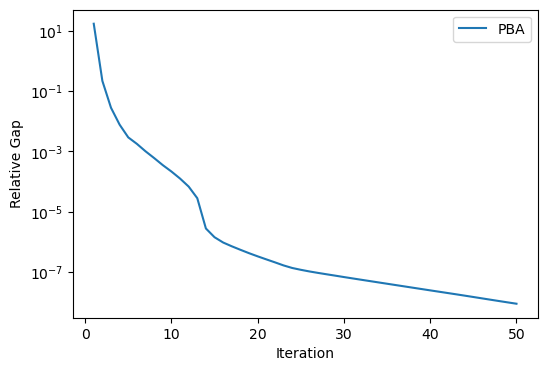

In [14]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(n_iters_pba,gaps_pba,label='PBA')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Gap')
ax.legend()

['4518.70', '8094.34', '4494.34', '5991.75', '8118.70', '14030.35', '9974.06', '5967.40', '8798.28', '12525.20', '14006.66', '18030.35', '5300.00', '10022.10', '8365.52', '12379.46', '18006.66', '8806.50', '15796.90', '5200.00', '17726.65', '8405.41', '9814.41', '15781.44', '6882.08', '21814.82', '12492.62', '12100.72', '6835.99', '8406.56', '12039.99', '15860.02', '15799.28', '15282.09', '18997.12', '8388.62', '11046.55', '11682.14', '15337.11', '21745.45', '17604.21', '23193.40', '11072.54', '8100.00', '23127.57', '9036.19', '19116.88', '18385.18', '8100.00', '11693.22', '9942.00', '9776.73', '9079.78', '8394.15', '12287.62', '11112.38', '11120.54', '10309.65', '7902.73', '8400.07', '9661.82', '7861.02', '19083.63', '9953.08', '8708.87', '18409.01', '7000.00', '8618.30', '9626.03', '18981.37', '8686.70', '6241.21', '7000.00', '6303.30', '8606.35', '10259.51']


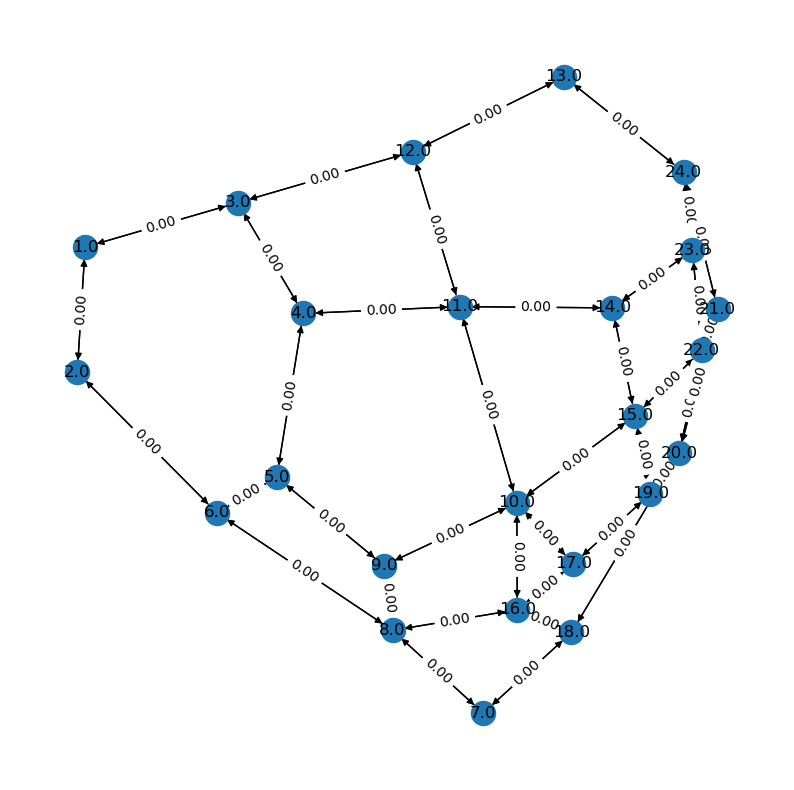

In [15]:
# Format the link_flow values to display with 2 digits
formatted_link_flow = [f'{flow:.2f}' for flow in model.link_flow]
print(formatted_link_flow)

# Create the plot
fig, ax = plt.subplots(figsize=(10,10))
G = model.get_graph()
pos = nx.spectral_layout(G)

# Draw the graph with labels
nx.draw(G, pos, with_labels=True)

# Add node labels
node_labels = nx.get_node_attributes(G, 'name')
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Add edge labels
edge_labels = nx.get_edge_attributes(G, 'travel_flow')

# Format edge labels to display with 2 digits
formatted_edge_labels = {edge: f'{flow:.2f}' for edge, flow in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels)

# Show the plot
plt.show()


In [16]:
# read the results

df_fw = pd.read_csv(f'results/{instance_name}/results_FW.csv', header=None, names=["iteration","gap","UE_cost"])
df_msa = pd.read_csv(f'results/{instance_name}/results_MSA.csv', header=None, names=["iteration","gap","UE_cost"])

In [17]:
df_pba = pd.read_csv(f'results/{instance_name}/results_PBA.csv', header=None, names=["iteration","gap","UE_cost"])

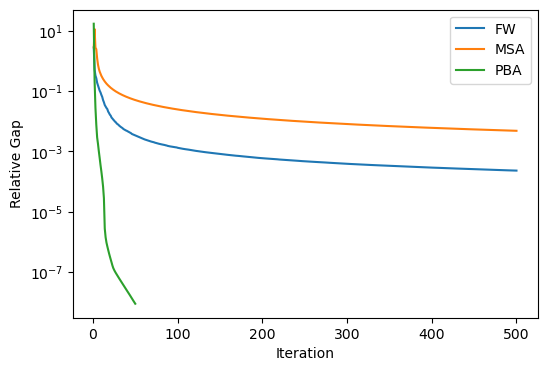

In [18]:
# plot the convergence curve
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(df_fw['iteration'],df_fw['gap'],label='FW')
ax.plot(df_msa['iteration'],df_msa['gap'],label='MSA')
ax.plot(df_pba['iteration'],df_pba['gap'],label='PBA')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Gap')
ax.legend()
plt.show()